# Using PDE find for symbolic regression to find equations

In [10]:
import torch
import sys
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import pysindy as ps

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN, NullWork
from architectures import FNN

In [11]:
class UPINN(UPINN):
    # Inductive bias on F
    def F_input(self, X, U):
        dudxt = torch.autograd.grad(U, X, torch.ones_like(U), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        u_x = dudxt[:,1:2]
        return torch.cat((U, u_t, u_x), dim=-1)
    
    # No inductive bias on F
    # def F_input(self, X, U):
    #     return torch.cat((X, U), dim=-1)

In [12]:
hidden = [20] * 8

u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.SiLU(),
    output_act=torch.nn.Identity(),
)

F = FNN(
    dims=[3, *hidden, 1],
    hidden_act=torch.nn.SiLU(),
    output_act=torch.nn.Identity(),
)

# Instantiate the UPINN
upinn = UPINN(u, NullWork(), F)

[Info]: Initializing UPINN model


### Load model

In [13]:
path = 'models'
name = 'burger_baseline_clean'
upinn.load(name, path)

### PDE find (SINDy)

In [14]:
train_shape = (256, 101)

t = np.linspace(0, 1, train_shape[1])
x = np.linspace(-1, 1, train_shape[0])
T, X = np.meshgrid(t, x)

T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).reshape(-1, 1)
X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)
Z_tensor = torch.cat((T_tensor, X_tensor), dim=-1)
Z_tensor.requires_grad_(True)
U_tensor = upinn.u(Z_tensor)
dUdZ = torch.autograd.grad(U_tensor, Z_tensor, torch.ones_like(U_tensor), create_graph=True)[0]
U_t = dUdZ[:, 0:1]
U_x = dUdZ[:, 1:2]
U_dot_tensor = upinn.F(upinn.F_input(Z_tensor, U_tensor))
U_dot = U_dot_tensor.detach().numpy().reshape(*train_shape, 1)

U = U_tensor.detach().numpy().reshape(*train_shape, 1)


### Function library

In [15]:
library_functions = [lambda x: x]
library_function_names = [lambda x: x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

### Modelfit with cross validation

In [16]:
# Find the best threshold using 10-fold cross-validation

cv_folds = TimeSeriesSplit(n_splits=10)
scores = []
taus = np.logspace(0, 2, 50)
for t_ in taus:
    optimizer = ps.SR3(
        threshold=t_, max_iter=10000, tol=1e-15, thresholder="l1", normalize_columns=True
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
    cv_scores = []
    for train_idx, test_idx in cv_folds.split(t):
        model.fit(x=U[:, train_idx], t=t[train_idx], x_dot=-U_dot[:, train_idx])
        cv_scores.append(model.score(x=U[:, test_idx], t=t[test_idx]))
    scores.append(np.mean(cv_scores))

best_t = taus[np.argmin(scores)]

optimizer = ps.SR3(
        threshold=best_t, max_iter=10000, tol=1e-15, thresholder='l1', normalize_columns=True
    )
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(x=U, t=t, x_dot=U_dot)

model.print()

(u)' = 0.574 u + -0.304 u_1 + 0.036 u_11 + -0.136 uu_1 + 0.015 uu_11


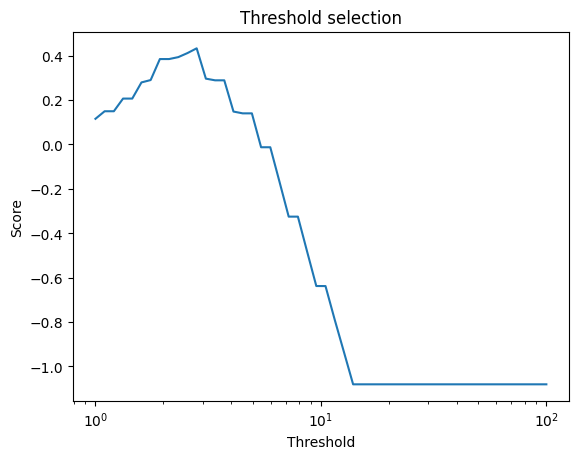

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(taus, scores)
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold selection')
plt.show()

In [89]:
RAD_upinn = UPINN(u, NullWork(), F)
RAD_upinn.load('tanh_burger_upinn', 'models')

[Info]: Initializing UPINN model
